In [1]:
#This notebook details all the necessary steps taken to prepare the data for frequency anomaly detection

In [2]:
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
#Importing Dataset
Dataframe = read_csv('Data_SDP_categorical.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [5]:
#For frequency analysis, we will only focus on importing time and Messages
Dataframe = Dataframe.drop(columns=['Source','Destination', 'Protocol','Length','Info'], axis=1)

In [6]:
#Drop the extra rows
Dataframe = Dataframe[:244042]

In [10]:
Dataframe

Time       Messages
0          0.111110  Read-Property
1          0.022244  Read-Property
2          0.036096           Tell
3          0.038743  Read-Property
4          0.098198  Read-Property
...             ...            ...
244037  7870.969316  Read-Property
244038  7870.980905  Read-Property
244039  7870.997703  Read-Property
244040  7871.043872  Read-Property
244041  7871.056932  Read-Property

[244042 rows x 2 columns]

In [12]:
#Splitting Dataset into training and testing randomly (80% training & 20% testing)
train_dataset, test_dataset = train_test_split(Dataframe, train_size=195234, test_size=48808, random_state=42)

In [14]:
train_dataset.sort_values(by=['Time'], inplace=True)

/Users/SOFIAN123/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
test_dataset.sort_values(by=['Time'], inplace=True)

/Users/SOFIAN123/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
train_dataset

Time       Messages
1          0.022244  Read-Property
2          0.036096           Tell
3          0.038743  Read-Property
0          0.111110  Read-Property
5          0.111526  Read-Property
...             ...            ...
244036  7870.897990  Read-Property
244037  7870.969316  Read-Property
244038  7870.980905  Read-Property
244039  7870.997703  Read-Property
244041  7871.056932  Read-Property

[195234 rows x 2 columns]

In [17]:
test_dataset

Time        Messages
4          0.098198   Read-Property
6          0.222184   Read-Property
11         0.487171   Read-Property
12         0.505225   Read-Property
22         0.847124  Write-Property
...             ...             ...
244028  7870.868233      Who-Router
244029  7870.868403      Who-Router
244031  7870.868474      Who-Router
244032  7870.868497      Who-Router
244040  7871.043872   Read-Property

[48808 rows x 2 columns]

In [18]:
#Splitting the data into different time intervals. 

#Create new dataframe for a time interval of 10 seconds
tenSeconds = test_dataset

#ten seconds intervals
f = 10
a = 0
b = 7900 #max. value
bins = [x * f for x in range(a, b)]
tenSeconds['Time'] = pd.cut(x=tenSeconds['Time'], bins=bins)

/Users/SOFIAN123/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [19]:
tenSeconds

Time        Messages
4            (0, 10]   Read-Property
6            (0, 10]   Read-Property
11           (0, 10]   Read-Property
12           (0, 10]   Read-Property
22           (0, 10]  Write-Property
...              ...             ...
244028  (7870, 7880]      Who-Router
244029  (7870, 7880]      Who-Router
244031  (7870, 7880]      Who-Router
244032  (7870, 7880]      Who-Router
244040  (7870, 7880]   Read-Property

[48808 rows x 2 columns]

In [20]:
#Creating a two-way frequency table with time intervals and message frequency for each interval
tenSecondsIntervals = tenSeconds['Time'].tolist()
tenSecondsIntervals = list(dict.fromkeys(tenSecondsIntervals))

message_class10 = pd.crosstab(index=tenSeconds["Time"], 
                            columns=tenSeconds["Messages"])

message_class10.columns = ["Ack-Message","At","I-am", "Read-Property", "Tell", "Unconfirmed-Transfer", "Who-Is", "Who-Router", "Write-Property"]
message_class10.index = tenSecondsIntervals

In [21]:
#the resulting frequency table
message_class10

Ack-Message  At  I-am  Read-Property  Tell  \
(0, 10]                 3   2     0             40     5   
(10, 20]                1   3     3             35     2   
(20, 30]                1   2     0             32     6   
(30, 40]                4   7     1             49     0   
(40, 50]                3   3     0             29     2   
...                   ...  ..   ...            ...   ...   
(7830, 7840]            1   7     0             36     4   
(7840, 7850]            4   8     3             34     2   
(7850, 7860]            1   7     0             28     4   
(7860, 7870]            5   4     0             34     3   
(7870, 7880]            0   1     0              2     0   

              Unconfirmed-Transfer  Who-Is  Who-Router  Write-Property  
(0, 10]                          1       1           5               1  
(10, 20]                         5       2           6               0  
(20, 30]                         7       3          12               1  
(30, 40]                         5       1           9              61  
(40, 50]                         4       1          12               1  
...                            ...     ...         ...             ...  
(7830, 7840]                    12       2           8               1  
(7840, 7850]                     4       3           3              93  
(7850, 7860]                     1       2           1               1  
(7860, 7870]                    10       2           1               0  
(7870, 7880]                     1       0           4               0  

[788 rows x 9 columns]

In [22]:
#statistics describing the frequency data
message_class10.describe()

Ack-Message          At        I-am  Read-Property        Tell  \
count   788.000000  788.000000  788.000000     788.000000  788.000000   
mean      2.414975    2.719543    0.670051      37.279188    3.190355   
std       1.527929    1.711394    1.137449       8.637451    1.811107   
min       0.000000    0.000000    0.000000       0.000000    0.000000   
25%       1.000000    1.000000    0.000000      34.000000    2.000000   
50%       2.000000    3.000000    0.000000      38.000000    3.000000   
75%       3.000000    4.000000    1.000000      42.000000    4.000000   
max       8.000000   11.000000    6.000000      59.000000   11.000000   

       Unconfirmed-Transfer      Who-Is  Who-Router  Write-Property  
count            788.000000  788.000000  788.000000      788.000000  
mean               5.247462    2.012690    5.865482        2.539340  
std                2.914876    1.479153    2.873385       11.544279  
min                0.000000    0.000000    0.000000        0.000000  
25%                3.000000    1.000000    4.000000        0.000000  
50%                5.000000    2.000000    6.000000        1.000000  
75%                7.000000    3.000000    8.000000        1.000000  
max               18.000000    8.000000   16.000000      117.000000

In [23]:
#As shown above, we can see that standard deviation is pretty small for each column. this signifies that the spread
#between the messages are the same. This will guarantee that atleast each observation (rows) will have balanced 
#representation of message frequencies at any time interval

In [26]:
#Now we apply the same time intervals for the testing data to be used later
#ten seconds intervals - test dataset

testIntervals = test_dataset['Time'].tolist()
testIntervals = list(dict.fromkeys(testIntervals))

message_classTest = pd.crosstab(index=test_dataset["Time"], 
                            columns=test_dataset["Messages"])

message_classTest.columns = ["Ack-Message","At","I-am", "Read-Property", "Tell", "Unconfirmed-Transfer", "Who-Is", "Who-Router", "Write-Property"]
message_classTest.index = testIntervals

In [27]:
message_classTest

Ack-Message  At  I-am  Read-Property  Tell  \
(0, 10]                 3   2     0             40     5   
(10, 20]                1   3     3             35     2   
(20, 30]                1   2     0             32     6   
(30, 40]                4   7     1             49     0   
(40, 50]                3   3     0             29     2   
...                   ...  ..   ...            ...   ...   
(7830, 7840]            1   7     0             36     4   
(7840, 7850]            4   8     3             34     2   
(7850, 7860]            1   7     0             28     4   
(7860, 7870]            5   4     0             34     3   
(7870, 7880]            0   1     0              2     0   

              Unconfirmed-Transfer  Who-Is  Who-Router  Write-Property  
(0, 10]                          1       1           5               1  
(10, 20]                         5       2           6               0  
(20, 30]                         7       3          12               1  
(30, 40]                         5       1           9              61  
(40, 50]                         4       1          12               1  
...                            ...     ...         ...             ...  
(7830, 7840]                    12       2           8               1  
(7840, 7850]                     4       3           3              93  
(7850, 7860]                     1       2           1               1  
(7860, 7870]                    10       2           1               0  
(7870, 7880]                     1       0           4               0  

[788 rows x 9 columns]

In [28]:
#Standardize the dataset so that data is internally consistent and has same content and format. Good for comparison

#Scaler function called..
scaler = StandardScaler()

#fit the scaler function on the training message, to get the parameters such as standard deviation and mean. 
scaler.fit(message_class10)

#Apply the parameters obtained on the training and testing.
trainData_std = scaler.transform(message_class10)
testData_std = scaler.transform(message_classTest) 

In [29]:
trainData_std

array([[ 0.38313108, -0.42070986, -0.58945608, ..., -0.68507672,
        -0.30139779, -0.13342694],
       [-0.92666195,  0.16398039,  2.04969956, ..., -0.00858492,
         0.04684482, -0.22010495],
       [-0.92666195, -0.42070986, -0.58945608, ...,  0.66790688,
         2.13630047, -0.13342694],
       ...,
       [-0.92666195,  2.50274138, -0.58945608, ..., -0.00858492,
        -1.69436822, -0.13342694],
       [ 1.69292412,  0.74867064, -0.58945608, ..., -0.00858492,
        -1.69436822, -0.22010495],
       [-1.58155847, -1.00540011, -0.58945608, ..., -1.36156853,
        -0.6496404 , -0.22010495]])

In [30]:
testData_std

array([[ 0.38313108, -0.42070986, -0.58945608, ..., -0.68507672,
        -0.30139779, -0.13342694],
       [-0.92666195,  0.16398039,  2.04969956, ..., -0.00858492,
         0.04684482, -0.22010495],
       [-0.92666195, -0.42070986, -0.58945608, ...,  0.66790688,
         2.13630047, -0.13342694],
       ...,
       [-0.92666195,  2.50274138, -0.58945608, ..., -0.00858492,
        -1.69436822, -0.13342694],
       [ 1.69292412,  0.74867064, -0.58945608, ..., -0.00858492,
        -1.69436822, -0.22010495],
       [-1.58155847, -1.00540011, -0.58945608, ..., -1.36156853,
        -0.6496404 , -0.22010495]])

In [31]:
#get column names
col_name = list(message_class10.columns)

#Converting standardized dataset to dataframe for easy view
train_normalized = pd.DataFrame(data=trainData_std, columns = col_name)
test_normalized = pd.DataFrame(data=testData_std, columns = col_name)

In [32]:
train_normalized

Ack-Message        At      I-am  Read-Property      Tell  \
0       0.383131 -0.420710 -0.589456       0.315202  0.999827   
1      -0.926662  0.163980  2.049700      -0.264040 -0.657670   
2      -0.926662 -0.420710 -0.589456      -0.611586  1.552326   
3       1.038028  2.502741  0.290262       1.357838 -1.762668   
4       0.383131  0.163980 -0.589456      -0.959131 -0.657670   
..           ...       ...       ...            ...       ...   
783    -0.926662  2.502741 -0.589456      -0.148192  0.447328   
784     1.038028  3.087432  2.049700      -0.379889 -0.657670   
785    -0.926662  2.502741 -0.589456      -1.074979  0.447328   
786     1.692924  0.748671 -0.589456      -0.379889 -0.105171   
787    -1.581558 -1.005400 -0.589456      -4.087038 -1.762668   

     Unconfirmed-Transfer    Who-Is  Who-Router  Write-Property  
0               -1.458093 -0.685077   -0.301398       -0.133427  
1               -0.084950 -0.008585    0.046845       -0.220105  
2                0.601621  0.667907    2.136300       -0.133427  
3               -0.084950 -0.685077    1.091573        5.067254  
4               -0.428236 -0.685077    2.136300       -0.133427  
..                    ...       ...         ...             ...  
783              2.318050 -0.008585    0.743330       -0.133427  
784             -0.428236  0.667907   -0.997883        7.840950  
785             -1.458093 -0.008585   -1.694368       -0.133427  
786              1.631478 -0.008585   -1.694368       -0.220105  
787             -1.458093 -1.361569   -0.649640       -0.220105  

[788 rows x 9 columns]

In [33]:
#as we can see below, the values will be on same scale and wont be affected by very large values that can affect 
#the learning capacity of the algorithm
train_normalized.describe()

Ack-Message            At          I-am  Read-Property          Tell  \
count  7.880000e+02  7.880000e+02  7.880000e+02   7.880000e+02  7.880000e+02   
mean  -1.417366e-16 -2.846003e-17 -8.650723e-17  -3.426475e-16 -1.608978e-16   
std    1.000635e+00  1.000635e+00  1.000635e+00   1.000635e+00  1.000635e+00   
min   -1.581558e+00 -1.590090e+00 -5.894561e-01  -4.318735e+00 -1.762668e+00   
25%   -9.266620e-01 -1.005400e+00 -5.894561e-01  -3.798887e-01 -6.576702e-01   
50%   -2.717654e-01  1.639804e-01 -5.894561e-01   8.350496e-02 -1.051711e-01   
75%    3.831311e-01  7.486706e-01  2.902625e-01   5.468987e-01  4.473279e-01   
max    3.657614e+00  4.841502e+00  4.688855e+00   2.516322e+00  4.314821e+00   

       Unconfirmed-Transfer        Who-Is    Who-Router  Write-Property  
count          7.880000e+02  7.880000e+02  7.880000e+02    7.880000e+02  
mean           3.099607e-17  9.073396e-17 -7.058651e-17    9.841254e-17  
std            1.000635e+00  1.000635e+00  1.000635e+00    1.000635e+00  
min           -1.801379e+00 -1.361569e+00 -2.042611e+00   -2.201050e-01  
25%           -7.715216e-01 -6.850767e-01 -6.496404e-01   -2.201050e-01  
50%           -8.495014e-02 -8.584921e-03  4.684482e-02   -1.334269e-01  
75%            6.016213e-01  6.679069e-01  7.433300e-01   -1.334269e-01  
max            4.377764e+00  4.050366e+00  3.529271e+00    9.921222e+00

In [34]:
#End of pre-processing for k-means

In [35]:
train_normalized.to_csv('train_normalized.csv')
test_normalized.to_csv('test_normalized.csv')

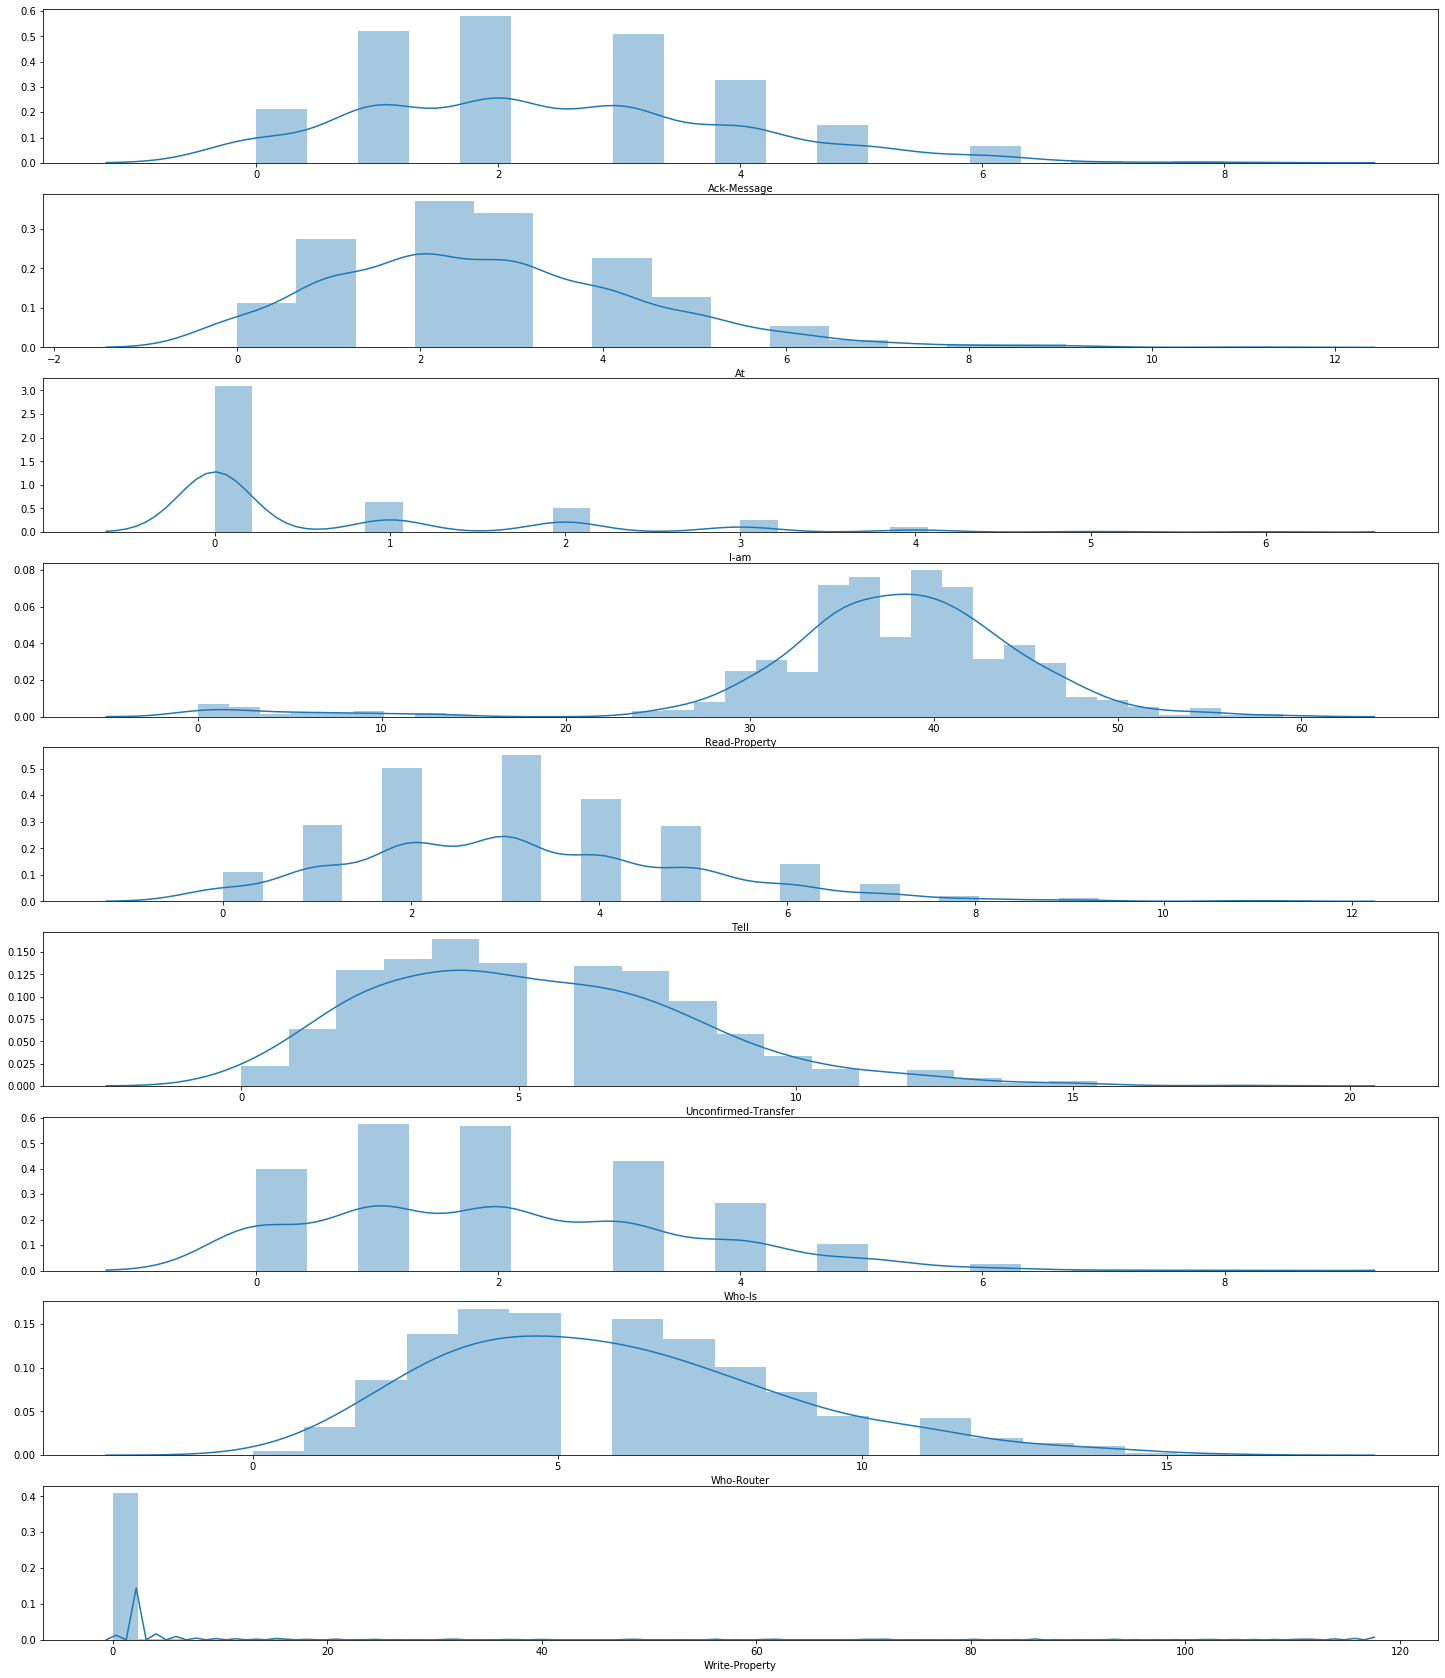

In [39]:
###Visualizing the data for seeing the distribution of messages 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
# Plot frequency distributions
plt.figure(figsize=(25,30))# Plot distribution of messages
plt.subplot(9, 1, 1); sns.distplot(message_class10['Ack-Message'])
plt.subplot(9, 1, 2); sns.distplot(message_class10['At'])
plt.subplot(9, 1, 3); sns.distplot(message_class10['I-am'])
plt.subplot(9, 1, 4); sns.distplot(message_class10['Read-Property'])
plt.subplot(9, 1, 5); sns.distplot(message_class10['Tell'])
plt.subplot(9, 1, 6); sns.distplot(message_class10['Unconfirmed-Transfer'])
plt.subplot(9, 1, 7); sns.distplot(message_class10['Who-Is'])
plt.subplot(9, 1, 8); sns.distplot(message_class10['Who-Router'])
plt.subplot(9, 1, 9); sns.distplot(message_class10['Write-Property'])
plt.show()

In [40]:
#End of preprocessing for k-means 